<a href="https://colab.research.google.com/github/AbrahamYesgat/C-Programming/blob/master/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pickle as pk
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm_notebook as tqdm
from sklearn import metrics
from PIL import Image
import random
from sklearn.metrics import f1_score, precision_score, roc_auc_score, recall_score, roc_curve
from sklearn.model_selection import train_test_split
import itertools
import math

#Dataset Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
class ISICDataset(Dataset):
    def __init__(self, im_path='ISIC-2017_Training_Data',
                 label_file='ISIC-2017_Training_Lesion_Labels.csv', transforms=None):
        super(ISICDataset, self).__init__()
        self.im_files = im_path
        self.lesion_labels = pd.read_csv(label_file).to_numpy()
        self.transforms = transforms

    def __getitem__(self, index):
        filename = self.lesion_labels[index][0]
        img = Image.open((self.im_files + '/' + filename + '.jpg'))
        lesion = self.lesion_labels[index][1]
        if self.transforms is not None:
            img = self.transforms(img)
        return img, lesion

    def __len__(self):
        return len(self.lesion_labels)



def get_dataset(p=1.0):
    label_file = '/content/drive/My Drive/ECSE_552_Project/ISIC-2017_Training_Lesion_Labels.csv'
    seg_file = '/content/drive/My Drive/ECSE_552_Project/ISIC-2017_Training_Segmentation'
    im_file = '/content/drive/My Drive/ECSE_552_Project/ISIC-2017_Training_Data'
    train_label = '/content/drive/My Drive/ECSE_552_Project/train1.csv'
    val_label = '/content/drive/My Drive/ECSE_552_Project/val1.csv'
    label_df = pd.read_csv(label_file)
    pos_labels = label_df[label_df['melanoma'] > 0.0].reset_index(drop=True)
    neg_labels = label_df[label_df['melanoma'] < 1.0].reset_index(drop=True)
    pos_train, pos_val = train_test_split(pos_labels, test_size=0.2)
    neg_train, neg_val = train_test_split(neg_labels, test_size=0.2)
    len_pos = len(pos_val)
    train = pd.concat([pos_train, neg_train]).sample(frac=p)
    val = pd.concat([pos_val, neg_val.iloc[:len_pos]])

    train.to_csv(train_label, index=False)
    val.to_csv(val_label, index=False)

    transform_train = transforms.Compose([transforms.Resize((256, 512)),
                                transforms.ToTensor(),
                                transforms.ColorJitter(0.25, 0.25, 0.25, 0.25),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomVerticalFlip(p=0.5)
                                ])

    transform_val = transforms.Compose([transforms.Resize((256, 512)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    train_set = ISICDataset(im_path=im_file, label_file=train_label, transforms=transform_train)
    val_set = ISICDataset(im_path=im_file, label_file=val_label, transforms=transform_val)


    return train_set, val_set


def get_testet():
    label_file = '/content/drive/My Drive/ECSE_552_Project/ISIC-2017_Testing_Lesion_Labels.csv'
    seg_file = '/content/drive/My Drive/ECSE_552_Project/ISIC-2017_Testing_Segmentation'
    im_file = '/content/drive/My Drive/ECSE_552_Project/ISIC-2017_Testing_Data'
    test_label = '/content/drive/My Drive/ECSE_552_Project/test.csv'
    label_df = pd.read_csv(label_file)
    pos_labels = label_df[label_df['melanoma'] > 0.0].reset_index(drop=True)
    neg_labels = label_df[label_df['melanoma'] < 1.0].reset_index(drop=True)
    test = pd.concat([pos_labels, neg_labels])

    test.to_csv(test_label, index=False)



    transform_test= transforms.Compose([transforms.Resize((256, 512)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    test_set = ISICDataset(im_path=im_file, label_file=test_label, transforms=transform_test)


    return test_set

In [ ]:
# %cd /content/drive/MyDrive/ECSE_552_Project
# %run utils.ipynb
label_file = '/content/drive/My Drive/ECSE_552_Project/ISIC-2017_Training_Lesion_Labels.csv'
seg_file = '/content/drive/My Drive/ECSE_552_Project/ISIC-2017_Training_Segmentation'
im_file = '/content/drive/My Drive/ECSE_552_Project/ISIC-2017_Training_Data'

train_set, val_set = get_dataset()#torch.utils.data.random_split(train_data, [train_len, val_len])
pos = sum(train_set.lesion_labels[:,1])
neg = len(train_set.lesion_labels) - (sum(train_set.lesion_labels[:,1]))
print("Number of positive labels in entire dataset: ",pos )
print("Number of negative labels in entire dataset: " , neg)
fraction = neg/pos
print("Fraction of negative to positive labels is: ", fraction)

Number of positive labels in entire dataset:  299.0
Number of negative labels in entire dataset:  1300.0
Fraction of negative to positive labels is:  4.3478260869565215


In [ ]:
path_backup = '/content/drive/My Drive/ECSE_552_Project/cls_model_backup_exp05.pth'
path_final = '/content/drive/My Drive/ECSE_552_Project/cls_model_exp05.pth'
path_record = '/content/drive/My Drive/ECSE_552_Project/cls_model_record.pth'

# Model Definition

In [ ]:
class Logger():
    def __init__(self, name):
        self.name = name
        self.train_loss = []
        self.val_loss = []

        self.train_acc = []
        self.val_acc = []

        self.train_recall = []
        self.val_recall = []

        self.train_f1score = []
        self.val_f1score = []

        self.train_precision = []
        self.val_precision = []
        self.test_acc = 0
        self.test_precision = 0
        self.test_recall = 0
        self.test_f1score = 0

        self.fpr = 0
        self.tpr = 0
        self.roc_auc = 0

        self.iterations = []
        self.epoch = 0
        self.test_performace = 0
        # add a means to save the model parameters and hyperparams maybe
        self.parameters = None

    def update(self, train_loss, val_loss, train_acc, val_acc, train_recall, val_recall, train_f1score, val_f1score, train_precision, val_precision):
        self.train_loss.append(train_loss)
        self.val_loss.append(val_loss)
        self.train_acc.append(train_acc)
        self.val_acc.append(val_acc)

        self.train_recall.append(train_recall)
        self.val_recall.append(val_recall)

        self.train_f1score.append(train_f1score)
        self.val_f1score.append(val_f1score)

        self.train_precision.append(train_precision)
        self.val_precision.append(val_precision)

        self.epoch += 1
        self.iterations.append(self.epoch)

    def display(self):
        print("Train Loss:", self.train_loss[-1])
        print("Val Loss:", self.val_loss[-1])
        print("Train Acc:", self.train_acc[-1])
        print("Val Acc:", self.val_acc[-1])

        print("Train Recall:", self.train_recall[-1])
        print("Val Recall:", self.val_recall[-1])
        print("Train F1-Score:", self.train_f1score[-1])
        print("Val F1-Score:", self.val_f1score[-1])
        print("Train Precision:", self.train_precision[-1])
        print("Val Precision:", self.val_precision[-1])

    def plot_loss(self):
        plt.plot(self.iterations, np.array(self.train_loss), label="Training Loss")
        plt.plot(self.iterations, np.array(self.val_loss), label="Validation Loss")
        plt.legend()
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.plot()
        plt.show()

    def plot_acc(self):
        plt.plot(self.iterations, np.array(self.train_acc), label="Training Accuracy")
        plt.plot(self.iterations, np.array(self.val_acc), label="Validation Accuracy")
        plt.legend()
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.plot()
        plt.show()


    def plot_recall(self):
        plt.plot(self.iterations, np.array(self.train_recall), label="Training Recall")
        plt.plot(self.iterations, np.array(self.val_recall), label="Validation Recall")
        plt.legend()
        plt.xlabel("Epoch")
        plt.ylabel("Recall")
        plt.plot()
        plt.show()


    def plot_roc(self):
        plt.title('Receiver Operating Characteristic')
        plt.plot(self.fpr, self.tpr, 'b', label = 'AUC = %0.2f' % self.roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

    def plot_f1score(self):
        plt.plot(self.iterations, np.array(self.train_f1score), label="Training f1-score")
        plt.plot(self.iterations, np.array(self.val_f1score), label="Validation f1-score")
        plt.legend()
        plt.xlabel("Epoch")
        plt.ylabel("F1-Score")
        plt.plot()
        plt.show()

    def plot_precision(self):
        plt.plot(self.iterations, np.array(self.train_precision), label="Training precision")
        plt.plot(self.iterations, np.array(self.val_precision), label="Validation precision")
        plt.legend()
        plt.xlabel("Epoch")
        plt.ylabel("Precision")
        plt.plot()
        plt.show()

    def save(self):
        pk.dump(self, open(name+".pk", 'wb'))


In [ ]:
class Classification():
    def __init__(self, mode='train', train_set=None, val_set=None,
                 test_set=None, lr=0.001, batch_size=8, weight_fraction = torch.tensor(4.3)):
        # set all hyperparameters here
        self.lr = lr
        self.batch_size = batch_size
        self.weight_fraction = weight_fraction
        self.net = models.vgg16(pretrained=True)

        self.net.classifier = nn.Sequential(
            nn.Dropout(0.5, inplace = False),
            nn.Linear(in_features=25088, out_features=1024, bias=True),
            self.net.classifier[1],
            self.net.classifier[2],
            nn.Linear(in_features=1024, out_features=1, bias=True),
        )

        # get data loaders from custom dataset
        if mode == 'train':
            self.train_loader = torch.utils.data.DataLoader(train_set, shuffle=True,batch_size=self.batch_size, drop_last = True)
            self.val_loader = torch.utils.data.DataLoader(val_set, shuffle=True,batch_size=self.batch_size, drop_last = True)
        else:
            self.test_loader = torch.utils.data.DataLoader(test_set, shuffle=True,batch_size=self.batch_size)

        # check gpu connection
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.net = self.net.to(self.device)

        # use ADAM optimizer
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=self.lr)

        self.logs = Logger(self.net.__class__.__name__)

    def train(self, max_epoch, weight_fraction):
        # set loss criteria
        if weight_fraction  == 0:
          weight_fraction = None
        self.weight_fraction = weight_fraction
        criterion = nn.BCEWithLogitsLoss(reduction='sum', pos_weight=weight_fraction)
        record = -math.inf
        for epoch in tqdm(range(max_epoch)):
            train_loss, val_loss = 0, 0
            train_acc, val_acc = 0, 0
            train_recall, val_recall = 0, 0
            train_f1score, val_f1score = 0, 0
            train_precision, val_precision = 0, 0

            train_acc, val_acc = 0, 0

            total = 0
            all_predictions, all_labels = [], []
            # training section
            self.net.train()
            total_scores = 0
            for img,lesion in self.train_loader:
                img, lesion = img.to(self.device), lesion.unsqueeze(1).float().to(self.device)
                self.optimizer.zero_grad()
                outputs = self.net(img)
                loss = criterion(outputs, lesion)

                prediction = torch.sigmoid(outputs)
                all_predictions.append(prediction.squeeze().cpu().flatten().tolist())
                all_labels.append(lesion.squeeze().cpu().flatten().tolist())
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()
                total += lesion.size(0)

            if epoch % 10 == 0:
              torch.save({
              'epoch': epoch,
              'model_state_dict': self.net.state_dict()
              }, path_backup)

            train_loss = train_loss / total
            train_precision, train_recall, train_f1score, train_acc = self.evaluate_performance(all_labels, all_predictions)


            print('Epoch Done', train_loss, train_acc)
            torch.save({
            'epoch': epoch,
            'model_state_dict': self.net.state_dict()
            }, path_final)

            # total = 0
            # self.net.eval()
            # all_predictions, all_labels = [], []
            # with torch.no_grad():
            #     for img, lesion in self.val_loader:
            #         img, lesion = img.to(self.device), lesion.unsqueeze(1).float().to(self.device)
            #         img = img.to(self.device)
            #         outputs = self.net(img)
            #         prediction = torch.sigmoid(outputs)

            #         all_predictions.append(prediction.squeeze().cpu().flatten().tolist())
            #         all_labels.append(lesion.squeeze().cpu().flatten().tolist())

            #         val_loss += criterion(outputs, lesion).item()
            #         total += lesion.size(0)

            # val_loss /= total
            # all_predictions = [item for sublist in all_predictions for item in sublist]
            # all_labels =  [item for sublist in all_labels for item in sublist]

            # val_precision, val_recall ,val_f1score, val_acc = self.evaluate_performance(all_labels,all_predictions)
            # if val_acc > record:
            #     print("Optimal Accuracy = ", val_acc, " ... saving model" )
            #     record = val_acc
            #     torch.save({
            #     'model_state_dict': self.net.state_dict()
            #     }, path_record)


            self.logs.update(train_loss, val_loss, train_acc, val_acc, train_recall, val_recall,train_f1score, val_f1score, train_precision, val_precision)
            print('Epoch:', epoch, "Train Loss:", train_loss, "Val Loss:",
                  val_loss, "Train Acc:", train_acc, "Val Acc:", val_acc, "Train recall:", train_recall, "Val: recall", val_recall)

    def evaluate_performance(self, all_labels, all_predictions):
      # function which returns the performance using a chosen metric
        all_labels = torch.tensor(all_labels)
        all_predictions = torch.tensor(all_predictions)
        all_labels = torch.flatten(all_labels)
        all_predictions = torch.flatten(all_predictions)
        all_predictions = (all_predictions.float() > 0.5).float()
        recall = recall_score(all_labels, all_predictions)
        accuracy = (torch.sum((all_predictions == all_labels).float()))/len(all_labels)
        precision = precision_score(all_labels, all_predictions)
        f1score = f1_score(all_labels, all_predictions)
        return precision, recall, f1score, accuracy

    def evaluate_test_performance(self, test_set):
        test_acc , test_precision, test_recall, test_f1score, total_scores = 0,0,0,0,0
        total = 0
        val_loss = 0
        criterion = nn.BCEWithLogitsLoss(reduction='sum', pos_weight=self.weight_fraction)
        self.net.eval()
        self.batch_size = 1
        self.test_loader = torch.utils.data.DataLoader(test_set, shuffle=True,batch_size=1)
        all_predictions, all_labels = [], []
        with torch.no_grad():
            for img, lesion in self.test_loader:
              img, lesion = img.to(self.device), lesion.unsqueeze(1).float().to(self.device)
              img = img.to(self.device)
              outputs = self.net(img)
              prediction = torch.sigmoid(outputs)

              all_predictions.append(prediction.squeeze().cpu().flatten().tolist())
              all_labels.append(lesion.squeeze().cpu().flatten().tolist())

              val_loss += criterion(outputs, lesion).item()
              total += lesion.size(0)

        val_loss /= total

        print(all_labels)
        print(all_predictions)

        all_predictions = list(itertools.chain.from_iterable(all_predictions))
        all_labels = list(itertools.chain.from_iterable(all_labels))
        print(all_predictions)
        print(all_labels)
        val_precision, val_recall ,val_f1score, val_acc = self.evaluate_performance(all_labels,all_predictions)


        fpr, tpr, threshold = roc_curve(all_labels, all_predictions)
        roc_auc = metrics.auc(fpr, tpr)
        self.logs.fpr = fpr
        self.logs.tpr = tpr
        self.logs.roc_auc = roc_auc
        self.logs.plot_roc()

        print("Accuracy: ", val_acc, "\nPrecision: ", val_precision , "\nRecall: ", val_recall, "\nF1-Score: ", val_f1score)


# Optimal Model

### Learning rate: 1e-6
### Batch Size: 8
### weight fraction: 4.37


### Reduced dataset, 100%, 75%, 50, 25


In [ ]:
train_set, val_set = get_dataset(p=0.5)
classification = Classification(train_set=train_set, val_set=val_set, lr=1e-6, batch_size=8, weight_fraction=torch.tensor(fraction))
classification.train(max_epoch=15, weight_fraction=torch.tensor(fraction))


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Epoch Done 1.1604180663824082 tensor(0.6025)
Epoch: 0 Train Loss: 1.1604180663824082 Val Loss: 0 Train Acc: tensor(0.6025) Val Acc: 0 Train recall: 0.21794871794871795 Val: recall 0
Epoch Done 1.1374368876218797 tensor(0.6662)
Epoch: 1 Train Loss: 1.1374368876218797 Val Loss: 0 Train Acc: tensor(0.6662) Val Acc: 0 Train recall: 0.3141025641025641 Val: recall 0
Epoch Done 1.1298175477981567 tensor(0.6363)
Epoch: 2 Train Loss: 1.1298175477981567 Val Loss: 0 Train Acc: tensor(0.6363) Val Acc: 0 Train recall: 0.5256410256410257 Val: recall 0
Epoch Done 1.1150602382421493 tensor(0.5875)
Epoch: 3 Train Loss: 1.1150602382421493 Val Loss: 0 Train Acc: tensor(0.5875) Val Acc: 0 Train recall: 0.6217948717948718 Val: recall 0
Epoch Done 1.1255245232582092 tensor(0.6037)
Epoch: 4 Train Loss: 1.1255245232582092 Val Loss: 0 Train Acc: tensor(0.6037) Val Acc: 0 Train recall: 0.5448717948717948 Val: recall 0
Epoch Done 1.0818469882011414 tensor(0.6137)
Epoch: 5 Train Loss: 1.0818469882011414 Val Loss:

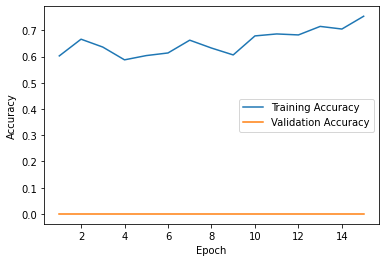

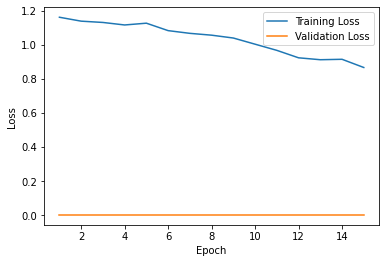

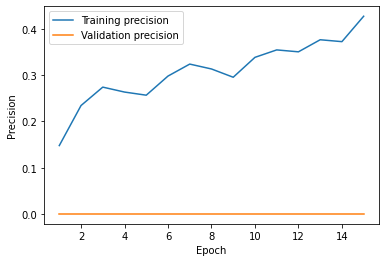

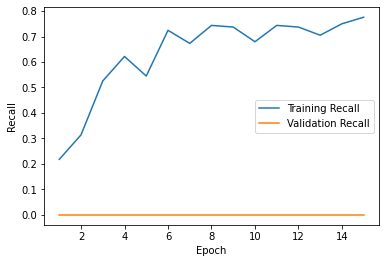

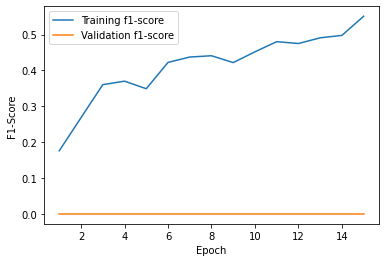

In [ ]:
classification.logs.plot_acc()
classification.logs.plot_loss()
classification.logs.plot_precision()
classification.logs.plot_recall()
classification.logs.plot_f1score()

# Test Set


We continue by now running our optimally trained model on our test set, and assess the results obtained. This will give us an idea of how our model performs in real life scenarios with images that have yet to be seen.

[[0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]

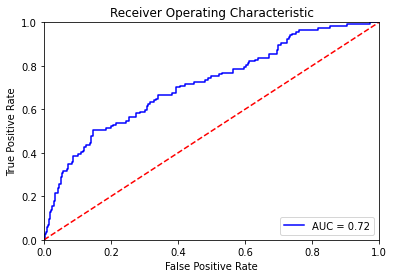

Accuracy:  tensor(0.6750) 
Precision:  0.32432432432432434 
Recall:  0.6153846153846154 
F1-Score:  0.4247787610619469


In [ ]:
test_set = get_testet()
classification_test = Classification(train_set=train_set, val_set=val_set, lr=1e-6, batch_size=8, weight_fraction=torch.tensor(fraction))
classification_test.net.load_state_dict(torch.load(path_final)['model_state_dict'])

classification_test.net.eval()
classification_test.evaluate_test_performance(test_set)